# Mod6L5 Data Challenge — Interpreting SLR Output (Dec 2023 NYC Taxi)


**Format:** We Do (Instructor prompts) → You Do (Student work) → We Share (reflection)


**Goal:** Choose **one** dependent variable (**Y**) from the taxi dataset and build **three** simple linear regressions (each with a different single **X**) on **Dec 2023** rides. For each model, interpret the **coefficient**, **intercept**, **p‑value**, and **R‑squared** in plain business language. Then decide which model is “better” *for decision‑making* and why.


> **Reminder:** No train/test split or advanced metrics today. We focus on reading `.summary()` and communicating results.

## Instructor Section (10 mins)

**Follow these steps/considerations as you work**


1) **Pick a useful Y.** Which outcome would someone actually act on?  Who is the stakeholder for your Y?

*Avoid constructing Y that bakes in your X (e.g., avoid using `fare_amount` as X when Y = `total_amount` which already includes fare).*


2) **Choose three X’s** you can know at decision time, and that plausibly relate to Y. 

*You may engineer a feature to use in the model if you like*

*Note:  SLR needs numeric only inputs so variables like `PULocationID` can't be used (categorical → not for SLR today unless you transform; stick to numeric X for this exercise)*


3) **Interpretation lenses:**
- **Units:** Always state slope in units (e.g., “per mile”, “per minute”).
- **p‑value:** Does evidence suggest the slope ≠ 0?
- **R²:** How much of Y’s variation is captured by this X? Does that help the decision?
- **Intercept:** Is X=0 meaningful? If not, say it’s a math anchor.
- **Plausibility:** Does the direction/size make sense (e.g., longer trip → higher fare)?


4) **Better ≠ only higher R².** Weigh **interpretability**, **actionability**, and **evidence** (p‑value, CI) alongside R².

## YOU DO (40 mins)

### Step 1: Read in the Data & Choose your **Y** (dependent variable)

Pick one from the 2023_Yellow_Taxi_Trip_Data_20251015 csv file  

In [110]:
# import packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [111]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_63125/2497641473.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


In [112]:
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3.0,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10.0,5.0,0.5,0.0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0.0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0.0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3.0,0.0,1.0,31.4,2.5,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,3.310907e+06,3.133527e+06,3.133527e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.133527e+06,3.133527e+06
mean,1.750368e+00,1.409560e+00,1.784972e+00,1.650685e+02,1.639182e+02,1.168633e+00,1.485240e+00,4.828656e-01,5.734011e-01,9.758456e-01,2.270032e+00,1.367974e-01
std,4.356449e-01,9.117169e-01,8.283274e+00,6.428330e+01,6.968454e+01,5.959677e-01,1.814139e+00,1.206643e-01,2.228458e+00,2.170912e-01,8.078364e-01,4.796868e-01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-3.917000e+01,-5.000000e-01,-7.000000e+01,-1.000000e+00,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.168000e+01,4.217000e+01,1.613800e+02,1.000000e+00,2.500000e+00,1.750000e+00


In [113]:
df.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

The response variable (Y) I chose is `total_amount`, representing the total fare charged for a taxi trip. I think this outcome is meaningful for my stakeholders, the `taxi company`, who aim to understand which trip factors most influence earnings. My stakeholders can act on this information to optimize pricing, scheduling, and customer service strategies.

### Step 2: Propose three candidate **X** predictors (numeric)

Pick three different X columns that are **numeric** and **known at decision time**.  
- The first x-variable is `trip_distance` because longer trips lead to higher fares; this is the single strongest predictor of total amount.  
- The second x-variable is `passenger_count` because sometimes more passengers can slightly increase fares, especially if larger groups take longer trips.  
- The third x-variable is `payment_type` because the payment method (cash vs. card) can affect total fares indirectly. For example, card payments might include automatic tips or additional surcharges.  

I selected `trip_distance`, `passenger_count`, and `payment_type` as predictors of `total_amount`. All three are known at or before the start of a trip, making them valid inputs for a predictive model.


### Step 3: Fit three one‑variable models with the SAME Y and different Xs

In [114]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count', 'total_amount']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')
# Clean data some and add a new column called ‘tip_pct’ as the target
df = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0) & (df['total_amount'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)

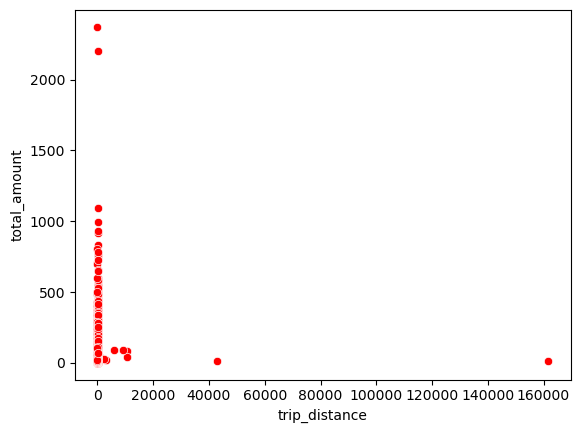

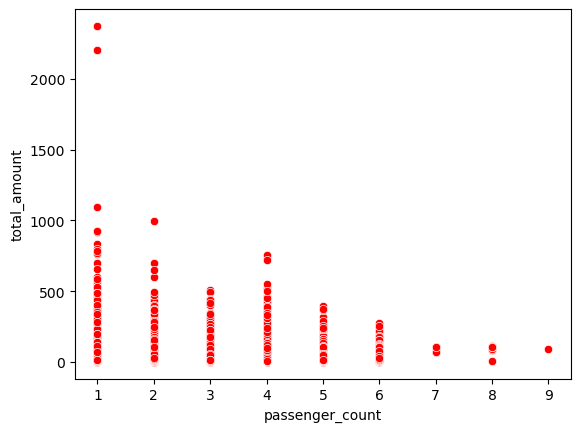

In [118]:
import matplotlib.pyplot as plt 
import seaborn as sns
list_col = ['trip_distance', 'passenger_count']
for _ in list_col:
    fig = plt.figure()
    #sns.scatterplot(data=df, x=_, y='total_amount', color='red')
    sns.scatterplot(data=df, x=_, y='total_amount', color='red')
    plt.show()

Let's handle the outliers, before building the model


In [119]:
list_col = ['trip_distance', 'passenger_count']
for _ in list_col:
    Q1 = df[_].quantile(0.25)
    Q3 = df[_].quantile(0.95)
    IQR = Q3 - Q1
    df = df[(df[_] >= Q1 - 1.5*IQR) & (df[_] <= Q3 + 1.5*IQR)]

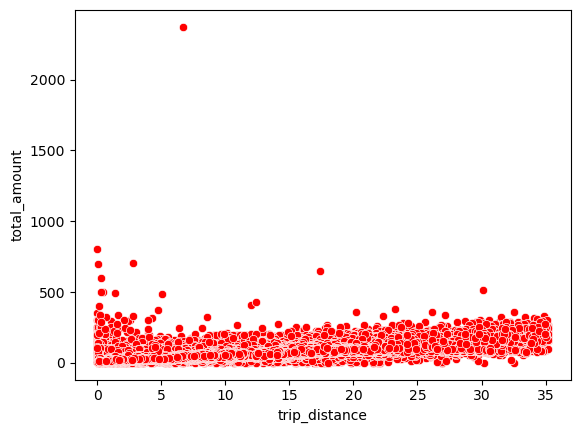

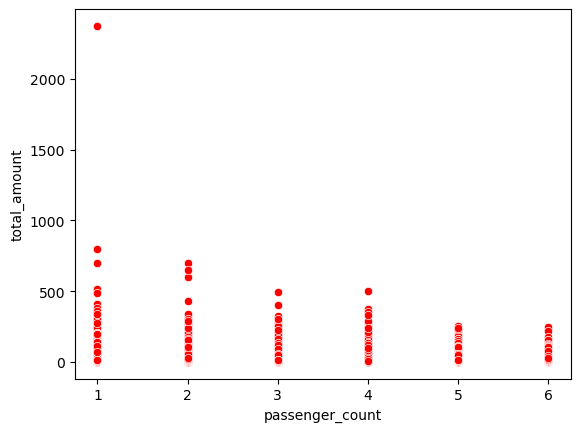

In [120]:
list_col = ['trip_distance', 'passenger_count']
for _ in list_col:
    fig = plt.figure()
    #sns.scatterplot(data=df, x=_, y='total_amount', color='red')
    sns.scatterplot(data=df, x=_, y='total_amount', color='red')
    plt.show()

### 1. Total amount vs Trip distance

In [121]:
import statsmodels.api as sm

x = sm.add_constant(df[['trip_distance']])  # independent variable(s)
y = df['total_amount']  # dependent variable

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 1.627e+07
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:48:18   Log-Likelihood:            -1.0797e+07
No. Observations:             3014548   AIC:                         2.159e+07
Df Residuals:                 3014546   BIC:                         2.159e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4968      0.006   2137.830

### 1. Total amount vs Passenger count

In [122]:
import statsmodels.api as sm

x = sm.add_constant(df[['passenger_count']])  # independent variable(s)
y = df['total_amount']  # dependent variable

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8002.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:48:35   Log-Likelihood:            -1.3591e+07
No. Observations:             3014548   AIC:                         2.718e+07
Df Residuals:                 3014546   BIC:                         2.718e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.2161      0.024   11

In [123]:
import statsmodels.api as sm

x = sm.add_constant(df[['payment_type']])  # independent variable(s)
y = df['total_amount']  # dependent variable

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.661e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:48:47   Log-Likelihood:            -1.3586e+07
No. Observations:             3014548   AIC:                         2.717e+07
Df Residuals:                 3014546   BIC:                         2.717e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           33.1822      0.035    953.854   

In [124]:
total_amount_vs_trip_distance = ols('total_amount ~ passenger_count', data=df).fit()
total_amount_vs_trip_distance.params

Intercept          27.216139
passenger_count     1.252457
dtype: float64

### Step 4: Visual check for the “best” model candidate

Pick the model you currently prefer (based on business sense + evidence).
- Create a scatter of X vs. Y with the fitted line.

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

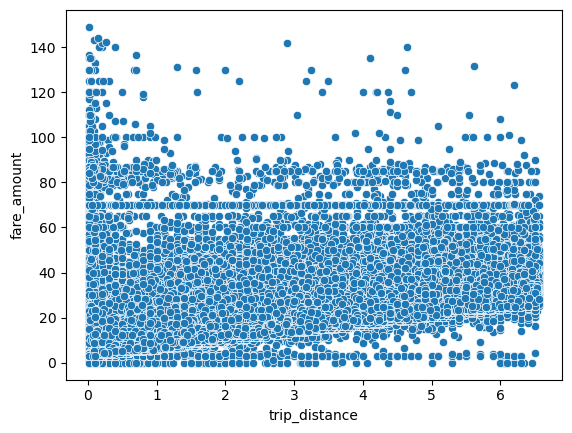

In [60]:
df_filter = df['fare_amount'] < 150
plot_df = df[df_filter]
sns.scatterplot(data=plot_df, x='trip_distance',y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='total_amount'>

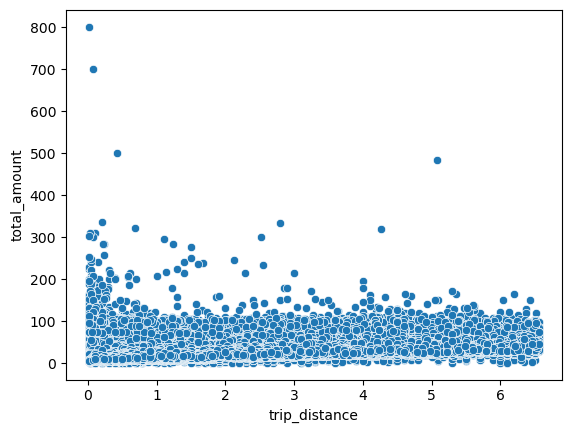

In [57]:
sns.scatterplot(data=df, x='trip_distance',y='total_amount')

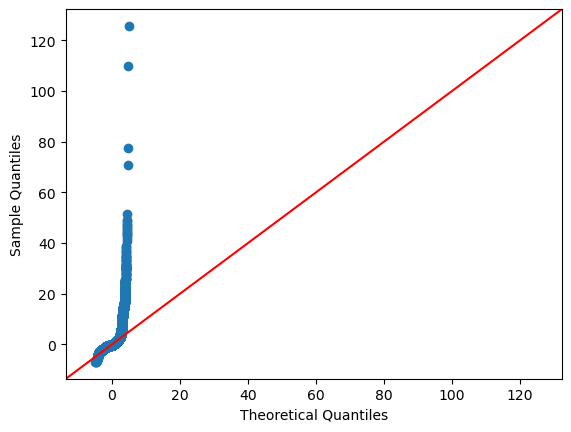

In [54]:
import statsmodels.api as sm

x = sm.add_constant(df[['trip_distance']])  # independent variable(s)
y = df['total_amount']  # dependent variable

model = sm.OLS(y, x).fit()
#print(model.summary())
residuals = model.resid
sm.qqplot(residuals, line='45', fit=True)  # Q–Q plot
plt.show()

### Step 5: Interpret Each Model (write in plain English)
Fill the three blocks below. Use **units** and **percentage points (pp)** where relevant.

- **Slope (β₁):** “For each +1 unit of X, Y changes by …”
- **Intercept (β₀):** meaningful or just a math anchor? Explain.
- **p‑value:** is there evidence the slope ≠ 0?
- **R²:** how much variation does this X explain?
- **Judgment:** is the effect size **practically** meaningful (tie to business)?

### Model A — Y = {{total_amount}} ~ X1 = {{trip_distance}}
- Slope (β₁): for each additional 1 miles, the model predict $4.65 increase in the total_amount. This is a positive quantitative relationship.
- Intercept (β₀): With 0 mile ride, our baseline amount is predicted to be $13.49. This is our starting point. but that make no sence because no trip has 0 miles for a taxi ride in general 
- p‑value (slope): The p-value for `trip_distance` is 0.000. The relationship between trip distance and total amount is statistically significant; it is highly unlikely to be a result of random chance.
- 95% CI for slope: Each extra mile is associated with +0.7 pp in the total amount (95%CI [0.025, 0.975], p<0.01).”
- R²: 84% of the variation in total amount of a ride can be explained by our trip distance.
- Business readout (units): There is a strong and practically meaningful effect between the distance and total amount. And this indicates that the trip distance is a very strong driver of the total amount spend during a ride. 
- One limitation: Event if the two variable are strongly related together, that does not always explain the causation. So, it is not enough to conclude directly the effect, we should check other and factors

### Model B — Y = {{total_amount}} ~ X2 = {{passenger_count}}
- Slope (β₁): for each additional passenger, the model predict $1.25 increase in the total_amount in average. This is a positive quantitative relationship.
- Intercept (β₀): With no passenger, our baseline amount is predicted to be $27.21. This is our starting point.(which is not realistic)
- p‑value (slope): The p-value for `passenger_count` is 0.000. The relationship between passenger count and total amount is statistically significant; it is highly unlikely to be a result of random chance.
- 95% CI for slope: Each extra passenger is associated with +0.7 pp in the total amount (95%CI [0.025, 0.975], p<0.01).”
- R²: 0.3% of the variation in total amount of a ride can be explained by our passenger count. R-squared of 0.3 suggests the model's predictions are not very close to the actual data points, meaning it has a lower "goodness of fit."
- Business readout (units): the effect is statistically significant but not practically meaningful. More passengers slightly raise fares, but this change is too small to matter for decision-making.
- One limitation: we cannot trust this variable as a reliable predictor.

### Model C — Y = {{total_amount}} ~ X3 = {{payment_type}}
- Slope (β₁): for each variation on the payement type, the model predict a decrease in the total_amount of approximately $3.48, on average. This is a negative quantitative relationship.
- Intercept (β₀): With no payement, our baseline amount is predicted to be $33.18. This is our starting point.(Which does't exit)
- p‑value (slope): The p-value for `payment_type` is 0.000. The relationship between payment type and total amount is statistically significant; it is highly unlikely to be a result of random chance.
- 95% CI for slope: Each payement type is associated with +0.7 pp in the total amount (95%CI [0.025, 0.975], p<0.01).”
- R²: 0.5% of the variation in total amount of a ride can be explained by our payment type. R-squared of 0.5 suggests the model's predictions are not very close to the actual data points, meaning it has a lower "goodness of fit."
- Business readout (units): the relationship between the response variable and the predictor variable is statistically significant but not practically meaningful.
- One limitation: The observed relationship is likely due to random variation or a spurious correlation, and we should not make business decisions based on it.

## We Share (10 mins) — Reflection & Decision (write 1-2 short paragraphs)

1) **Which model is “better” for a stakeholder decision and why?**
- Weigh **evidence** (p‑value, CI), **explanatory power** (R²), **interpretability**, and **business impact** (units, MDE if relevant).
2) **What would you do next week to strengthen trust in this model?**
- (Preview) time‑based validation, hold‑out testing, segment checks, adding more plausible X’s, checking assumptions.

For the three simple linear regression models, `trip_distance` was the best predictor of `total_amount`. Its model achieved an R² of 0.844, showing that trip distance alone explains about 84% of the variation in total amount — a very strong relationship. On average, each additional mile increased the fare by roughly $4.66, which aligns well with real-world expectations. In the order hand, `passenger_count` and `payment_type` both showed very low explanatory power (R² < 1%). Although their p-values were statistically significant due to the large sample size, their slopes ($1.25 and –$3.48, respectively) are too small to be practically meaningful. This suggests that while passenger number or payment method may slightly influence total fare, they do not drive revenue compared to distance.
The next step would be to check the assumptions made by examinating residual plots to confirm linearity, also communicate uncertainty by reporting confidence intervalle to make the result transparent to my skatesholders. 